# 03 - Treinamento dos Modelos

Neste notebook, é realizada a validação do treinamento de diferentes modelos treinados a partir dos dados pré-tratados anteriormente.

## Importação

In [1]:
# Bibliotecas padrão
import pickle
import warnings
import os
from datetime import datetime as dt
from collections import Counter

# Bibliotecas utilitárias de terceiros
import numpy as np
import pandas as pd
import scipy.stats as ss
from tqdm.notebook import tqdm

# Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# Funções de avaliação e seleção de modelos
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
# Para escalonamento de dados e pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Gráficos
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

## Constantes e Sets

In [2]:
# PALETTE = 'RdYlGn'
# PALETTE = 'viridis'
# PALETTE = 'inferno'
PALETTE = 'balance'
BLUE = '#346CB5'
SEED = 42
N_ITER = 20  # Podemos diminuir
TRAINVAL_SPLITS = 3  # Parece um número bom pra mim! 3, 5, 10...
FONT_SIZE = 16

warnings.simplefilter('ignore'); os.environ['PYTHONWARNINGS'] = 'ignore'  # Para remover warnings desnecessários que só poluem o notebook
pd.set_option('display.max_columns', None)
np.random.seed(SEED)

pio.templates['bigger-font'] = pio.templates['plotly']
pio.templates['bigger-font']['layout']['font']['size'] = FONT_SIZE  # Usado para exportar para png

pio.templates.default = 'plotly'  # Usado para visualizar no notebook

## Funções

In [3]:
def generate_colors(num_colors):
    colors = px.colors.sample_colorscale(PALETTE, [n/(num_colors - 1) for n in range(num_colors)])
    
    return colors

In [4]:
def validate_model(model, X, y, param_grid, targets_map={}, n_iter=10, n_trainval_splits=10):
    skf = StratifiedKFold(n_splits=n_iter, random_state=SEED, shuffle=True)   # Shuffle?
    skf_folds = skf.split(X, y)
    
    runs_metrics = {}

    for n, (trainval_idx, test_idx) in enumerate(tqdm(skf_folds, total=n_iter)):
        X_trainval = X[trainval_idx]
        y_trainval = y[trainval_idx]
        
        X_test = X[test_idx]
        y_test = y[test_idx]
    
        best_params = get_best_params(model, X_trainval, y_trainval, param_grid, n_trainval_splits=n_trainval_splits, 
                                      display_results=False)

        t0 = dt.now()
        model.set_params(**best_params)
        model.fit(X_trainval, y_trainval)    
        tf = dt.now()
        t_delta = tf - t0
        
        model_metrics = evaluate_model_performance(model, X_test, y_test, targets_map=targets_map)
        model_metrics['best_params'] = best_params
        model_metrics['training_time'] = t_delta
        runs_metrics[n] = model_metrics
    
    runs_metrics = aggregate_run_metrics(runs_metrics)
    return runs_metrics

In [5]:
def get_best_params(model, X_trainval, y_trainval, param_grid, n_trainval_splits=10, display_results=False):
    skf = StratifiedKFold(n_splits=n_trainval_splits, random_state=SEED, shuffle=True)  # Shuffle?
    
    grid_search = GridSearchCV(model, param_grid=param_grid, refit=False, cv=skf, n_jobs=-1)
    grid_search.fit(X_trainval, y_trainval)
    
    best_params = grid_search.best_params_

    if display_results:
        df_res = pd.DataFrame(grid_search.cv_results_)
        df_res = df_res.sort_values('rank_test_score', ascending=True)
        display(df_res)

    return best_params

In [6]:
def evaluate_model_performance(model, X, y, targets_map={}):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    if targets_map != {}:
        target_names = [targets_map[yy] for yy in np.unique(y)]

    else:
        target_names = None
            
    report_dict = classification_report(y, y_pred, output_dict=True, target_names=target_names)
    report_dict['cm'] = cm

    return report_dict

In [7]:
def aggregate_run_metrics(runs_res):
    runs_ids = runs_res.keys()
    labels = [label for label in runs_res[0].keys() if label not in ['accuracy', 'micro avg', 'best_params', 'macro avg', 
                                                                     'weighted avg', 'training_time', 'cm']]  # Porco?

    accuracies = [runs_res[i]['accuracy'] for i in runs_ids]
    cms = [runs_res[i]['cm'] for i in runs_ids]
    f1_scores = {i: [runs_res[j][i]['f1-score'] for j in runs_ids] for i in labels}
    recalls = {i: [runs_res[j][i]['recall'] for j in runs_ids] for i in labels}
    precisions = {i: [runs_res[j][i]['precision'] for j in runs_ids] for i in labels}
    best_params = [runs_res[i]['best_params'] for i in runs_ids]
    training_time = [runs_res[i]['training_time'] for i in runs_ids]

    metrics = {
        'accuracies': accuracies,
        'cms': cms,
        'f1-scores': f1_scores,
        'recalls': recalls,
        'precisions': precisions,
        'best_params': best_params,
        'training_time': training_time
      }

    return metrics

In [8]:
def print_res(res):  # Cumulo da porquice, mas funciona bem
    mean_acc = np.mean(res['accuracies']) * 100
    std_acc = np.std(res['accuracies'], ddof=1) * 100
    
    print(f"===> ACURÁCIA MÉDIA <===\n({mean_acc:.2f} ± {std_acc:.2f})%", end='\n\n')
    print(f"===> MATRIZ DE CONFUSÃO GERAL <===\n{np.sum(res['cms'], axis=0)}", end='\n\n')
    
    print('===> RECALL, PRECISION E F1-SCORE MÉDIO <===') 
    print(f"{'Target'.ljust(12)} | {'Recall'.ljust(12)} (%) | {'Precision'.ljust(12)} (%) | {'F1-Score'.ljust(12)} (%)")
    print('-'*70)
    mean_recalls = []
    mean_precisions = []
    mean_f1_scores = []
    for l in res['recalls'].keys():  # Igual para todos
        mean_recall = np.mean(res['recalls'][l]) * 100
        mean_precision = np.mean(res['precisions'][l]) * 100
        mean_f1_score = np.mean(res['f1-scores'][l]) * 100

        std_recall = np.std(res['recalls'][l], ddof=1) * 100
        std_precision = np.std(res['precisions'][l], ddof=1) * 100
        std_f1_score = np.std(res['f1-scores'][l], ddof=1) * 100

        mean_recalls.append(mean_recall)
        mean_precisions.append(mean_precision)
        mean_f1_scores.append(mean_f1_score)
        
        print(f'{l.ljust(12)} | '
              f'{(str(np.round(mean_recall, 2)) + " ± " + str(np.round(std_recall, 2))).ljust(16)} | '
              f'{(str(np.round(mean_precision, 2)) + " ± " + str(np.round(std_precision, 2))).ljust(16)} | '
              f'{(str(np.round(mean_f1_score, 2)) + " ± " + str(np.round(std_f1_score, 2))).ljust(16)}')

    std_recalls = np.std(mean_recalls, ddof=1)
    std_precisions = np.std(mean_precisions, ddof=1)
    std_f1_scores = np.std(mean_f1_scores, ddof=1)
    
    mean_recalls = np.mean(mean_recalls)
    mean_precisions = np.mean(mean_precisions)
    mean_f1_scores = np.mean(mean_f1_scores)
    
    print(f"\n===> MÉDIA DO RECALL MÉDIO <===\n({mean_recalls:.2f} ± {std_recalls:.2f})%", end='\n\n')
    print(f"===> MÉDIA DO PRECISION MÉDIO <===\n({mean_precisions:.2f} ± {std_precisions:.2f})%", end='\n\n')
    print(f"===> MÉDIA DO F1-SCORE MÉDIO <===\n({mean_f1_scores:.2f} ± {std_f1_scores:.2f})%", end='\n\n')

    print('\n===> MELHORES HIPERPARÂMETROS <===') 
    print(f"{'Ocorrências'.ljust(12)} | {'Valores'.ljust(75)}")
    print('-'*130)
    params_counts = Counter(tuple(param.items()) for param in res['best_params'])
    params_counts_mc = params_counts.most_common()
    
    for pcm in params_counts_mc:  # [:5] para mostrar apenas top 5
        pcm_values = pcm[0]
        pcm_occ = pcm[1]
    
        print(f'{str(pcm_occ).ljust(12)} | {pcm_values}')

    print(f"\n===> TEMPO DE TREINAMENTO MÉDIO <===\n{np.mean(res['training_time'])}")

In [9]:
def plot_accuracies(res, export=False, filename='acc', path='.'):
    accuracies = [r*100 for r in res['accuracies']]  # Acho que fica melhor em percentual
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=accuracies, nbinsx=5, marker_color=BLUE))
    fig.add_vline(x=np.mean(accuracies), line_dash='dash', annotation_text=f' Acurácia Média: {np.mean(accuracies):.2f}%')
    fig.update_layout(title=f'Distribuição das Acurácias após {N_ITER} iterações', yaxis_title='Frequência', xaxis_title='Acurácia (%)',
                      height=600, autosize=True)

    if export:
        export_fig(fig, filename, path)
    
    fig.show()

In [10]:
def plot_label_metrics(res, metric, export=False, filename='label_metric', path='.'):
    label_score = {k: [v*100 for v in res[metric][k]] for k in res[metric].keys()}  # Percentual
    
    labels = list(label_score.keys())
    marker_colors = generate_colors(len(labels))

    fig = go.Figure()
    for i, l in enumerate(labels):
        color = marker_colors[i]
        f1_score = label_score[l]

        fig.add_trace(go.Box(y=f1_score, name=l, marker_color=color, legendgroup=i))#, boxpoints='all'))

    fig.update_layout(title=f'Boxplots de {metric.title()} por label após {N_ITER} iterações', yaxis_title=f"{metric.title()} (%)",
                      xaxis_title="Classes", yaxis_range=(0, 101), height=600, autosize=True)  # Para ter comparabilidade entre os modelos

    if export:
        export_fig(fig, filename, path)
    
    fig.show()

In [67]:
def plot_confusion_matrix(res, export=False, filename='cm', path='.'):
    cms = res['cms']
    axis_labels = list(res['recalls'].keys())  # Igual para todos
    
    cm = np.sum(cms, axis=0)
    cm_mean = np.mean(cms, axis=0)
    cm_recall = cm/np.sum(cm, axis=1)
    cm_precision = cm/np.sum(cm, axis=0)

    fig = make_subplots(rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.1,
                        subplot_titles=['Matriz de Confusão Somada', 'Matriz de Confusão Média', 
                                        'Matriz de Confusão normalizada por Recall', 
                                        'Matriz de confusão normalizada por Precision'])
    
    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm, text=cm, texttemplate='%{text}', 
                             showscale=False, colorscale=PALETTE), 
                  row=1, col=1)
    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm_mean, text=cm_mean, texttemplate='%{text:.2f}', 
                             showscale=False, colorscale=PALETTE), 
                  row=1, col=2)


    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm_recall, text=cm_recall, texttemplate='%{text:.2f}', 
                             showscale=False, colorscale=PALETTE), 
                  row=2, col=1)
    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm_precision, text=cm_precision, texttemplate='%{text:.2f}', 
                             showscale=False, colorscale=PALETTE), 
                  row=2, col=2)

    fig.update_layout(title=f'Matrizes de Confusão geradas após {N_ITER} iterações', yaxis1_title='Real', yaxis3_title='Real', 
                      xaxis3_title='Predito', xaxis4_title='Predito', yaxis1_autorange='reversed', yaxis2_autorange='reversed', 
                      yaxis3_autorange='reversed', height=1000, autosize=True)

    if export:
        export_fig(fig, filename, path)

    fig.show()

In [12]:
def export_fig(fig, filename, path):
    fig_png = go.Figure(fig)  # Deep copy para não alterar o objeto original
    fig_html = go.Figure(fig)

    fig_png = fig_png.update_layout(template='bigger-font', width=1100)  # Para cobrir toda lateral da pag
    fig_html = fig_html.update_layout(width=None, height=None, autosize=True)  # Para mudar conforme a página html

    fig_png.write_image(f'{path}/{filename}.png', scale=3)
    fig_html.write_html(f'{path}/{filename}.html')

## Scripts

### Leitura

#### Base de dados

Como primeiro passo vamos realizar a leitura dos dados pré-tratados anteriormente.

In [13]:
df = pd.read_pickle('../data/processed/steel-plates-fault.pkl')
df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target
0,42.0,50.0,270900.0,270944.0,267.0,17.0,44.0,24220.0,76.0,108.0,1687.0,1.0,0.0,80.0,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,0
1,645.0,651.0,2538079.0,2538108.0,108.0,10.0,30.0,11397.0,84.0,123.0,1687.0,1.0,0.0,80.0,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,0
2,829.0,835.0,1553913.0,1553931.0,71.0,8.0,19.0,7972.0,99.0,125.0,1623.0,1.0,0.0,100.0,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,0
3,853.0,860.0,369370.0,369415.0,176.0,13.0,45.0,18996.0,99.0,126.0,1353.0,0.0,1.0,290.0,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,0
4,1289.0,1306.0,498078.0,498335.0,2409.0,60.0,260.0,246930.0,37.0,126.0,1353.0,0.0,1.0,185.0,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,221.0,242.0,3948212.0,3948253.0,519.0,33.0,41.0,48309.0,65.0,124.0,1360.0,1.0,0.0,200.0,0.3250,0.3972,0.5122,0.0154,0.6364,1.0000,1.0,2.7152,1.3222,1.6128,0.4878,-0.2728,0.9765,5
1264,1111.0,1121.0,4032298.0,4032320.0,110.0,20.0,22.0,12351.0,100.0,127.0,1354.0,1.0,0.0,200.0,0.3442,0.5000,0.4545,0.0074,0.5000,1.0000,1.0,2.0414,1.0000,1.3424,0.5454,-0.1228,0.3663,5
1265,995.0,1006.0,4085316.0,4085344.0,140.0,25.0,28.0,16076.0,103.0,132.0,1356.0,1.0,0.0,200.0,0.5162,0.5454,0.3929,0.0081,0.4400,1.0000,1.0,2.1461,1.0414,1.4472,0.6071,-0.1029,0.5096,5
1266,396.0,418.0,4116853.0,4116868.0,231.0,26.0,16.0,25096.0,56.0,141.0,1356.0,1.0,0.0,200.0,0.5841,0.3000,0.6818,0.0162,0.8461,0.9375,0.0,2.3636,1.3424,1.1761,-0.3182,-0.1512,0.5461,5


In [14]:
df.dtypes

X_Minimum                float64
X_Maximum                float64
Y_Minimum                float64
Y_Maximum                float64
Pixels_Areas             float64
X_Perimeter              float64
Y_Perimeter              float64
Sum_of_Luminosity        float64
Minimum_of_Luminosity    float64
Maximum_of_Luminosity    float64
Length_of_Conveyer       float64
TypeOfSteel_A300         float64
TypeOfSteel_A400         float64
Steel_Plate_Thickness    float64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
Target                     int64
dtype: object

In [15]:
df.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Target
count,1268.000000,1268.000000,1.268000e+03,1.268000e+03,1268.000000,1268.000000,1268.000000,1.268000e+03,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.00000,1268.000000
mean,508.635647,565.126183,1.759791e+06,1.759855e+06,2588.908517,143.205836,103.716088,2.831348e+05,79.209779,130.299685,1445.250789,0.402997,0.597003,66.072555,0.310388,0.409378,0.589186,0.040520,0.597253,0.802600,0.562303,2.603358,1.388906,1.456804,0.067459,-0.135566,0.61065,2.695584
std,513.760815,481.284469,1.719432e+06,1.719449e+06,6107.392220,362.087198,524.113646,6.006898e+05,32.625475,16.654437,137.299471,0.490694,0.490694,35.923484,0.303147,0.134019,0.264234,0.062152,0.241613,0.241219,0.484225,0.880245,0.535012,0.468135,0.483909,0.137824,0.34960,1.802939
min,0.000000,6.000000,7.430000e+03,7.458000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,70.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.301000,0.301000,0.000000,-0.931900,-0.998900,0.11900,0.000000
25%,41.000000,191.000000,6.266300e+05,6.266358e+05,87.000000,15.000000,13.000000,1.011000e+04,46.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058500,0.314850,0.375700,0.006600,0.400000,0.539850,0.000000,1.939500,1.000000,1.079200,-0.364800,-0.192625,0.24820,1.000000
50%,283.000000,330.500000,1.412536e+06,1.412546e+06,200.500000,28.000000,28.000000,2.135150e+04,85.500000,127.000000,1362.000000,0.000000,1.000000,60.000000,0.181450,0.407450,0.571400,0.010150,0.633500,0.956500,1.000000,2.302100,1.176100,1.389050,0.072250,-0.143000,0.57080,2.000000
75%,955.000000,963.250000,2.246608e+06,2.246677e+06,3638.500000,184.250000,115.000000,3.696388e+05,103.000000,140.000000,1624.000000,1.000000,1.000000,70.000000,0.533050,0.493725,0.837025,0.067625,0.777800,1.000000,1.000000,3.560900,2.011750,1.812900,0.468275,-0.081650,1.00000,5.000000
max,1688.000000,1696.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,196.000000,252.000000,1794.000000,1.000000,1.000000,290.000000,0.992300,0.943900,1.000000,0.622600,1.000000,1.000000,1.000000,5.183700,2.938500,4.258700,0.991700,0.591700,1.00000,5.000000


#### Mapa dos targets

Em seguida, iremos realizar a importação do mapa dos targets. Isto irá facilitar na leitura dos gráficos e validação do problema:

In [16]:
with open('../data/processed/target_maps.pkl', 'rb') as file: 
    targets_map = pickle.load(file)

targets_map

{0: 'Pastry',
 1: 'Z_Scratch',
 2: 'K_Scatch',
 3: 'Stains',
 4: 'Dirtiness',
 5: 'Bumps',
 6: 'Other_Faults'}

### Divisão

Para este projeto, utilizaremos todas as variáveis disponíveis (exceto `target`) para realizar as predições. Assim, teremos:

In [17]:
X = df.drop(columns=['Target']).values
y = df['Target'].values

X.shape, y.shape

((1268, 27), (1268,))

### Treinamento

Definida a variável independente $\mathbf{X}$ e a variável alvo $\mathbf{y}$, podemos começar os treinamentos.

#### K-Nearest Neighbors (KNN)

In [18]:
knn_param_grid = {
    'model__n_neighbors': [5, 1, 3, 10],
    'model__p': [2, 1],
    'model__weights': ['uniform', 'distance']    
}

knn_model = Pipeline([('scaler', StandardScaler()) , ('model', KNeighborsClassifier())])
knn_res = validate_model(knn_model, X, y, knn_param_grid, targets_map=targets_map, n_iter=N_ITER, n_trainval_splits=TRAINVAL_SPLITS)
print_res(knn_res)

  0%|          | 0/20 [00:00<?, ?it/s]

===> ACURÁCIA MÉDIA <===
(88.88 ± 3.92)%

===> MATRIZ DE CONFUSÃO GERAL <===
[[105   4   0   0   1  48]
 [  3 176   4   0   0   7]
 [  2   2 382   0   0   5]
 [  0   1   0  68   0   3]
 [  2   1   0   0  51   1]
 [ 29  14   5   3   6 345]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Target       | Recall       (%) | Precision    (%) | F1-Score     (%)
----------------------------------------------------------------------
Pastry       | 66.52 ± 14.78    | 75.67 ± 12.17    | 69.75 ± 10.59   
Z_Scratch    | 92.56 ± 7.86     | 89.83 ± 9.54     | 90.82 ± 6.59    
K_Scatch     | 97.72 ± 3.05     | 97.78 ± 2.52     | 97.71 ± 1.83    
Stains       | 94.58 ± 13.86    | 96.75 ± 7.99     | 94.79 ± 9.25    
Dirtiness    | 93.33 ± 17.44    | 90.42 ± 15.83    | 89.69 ± 13.95   
Bumps        | 85.82 ± 7.59     | 84.89 ± 8.34     | 85.09 ± 6.3     

===> MÉDIA DO RECALL MÉDIO <===
(88.42 ± 11.42)%

===> MÉDIA DO PRECISION MÉDIO <===
(89.22 ± 8.18)%

===> MÉDIA DO F1-SCORE MÉDIO <===
(87.98 ± 9.93)%


In [46]:
plot_accuracies(knn_res, export=True, filename='knn_acc', path='../figs/metrics')

In [47]:
plot_label_metrics(knn_res, 'f1-scores', export=True, filename='knn_f1', path='../figs/metrics')

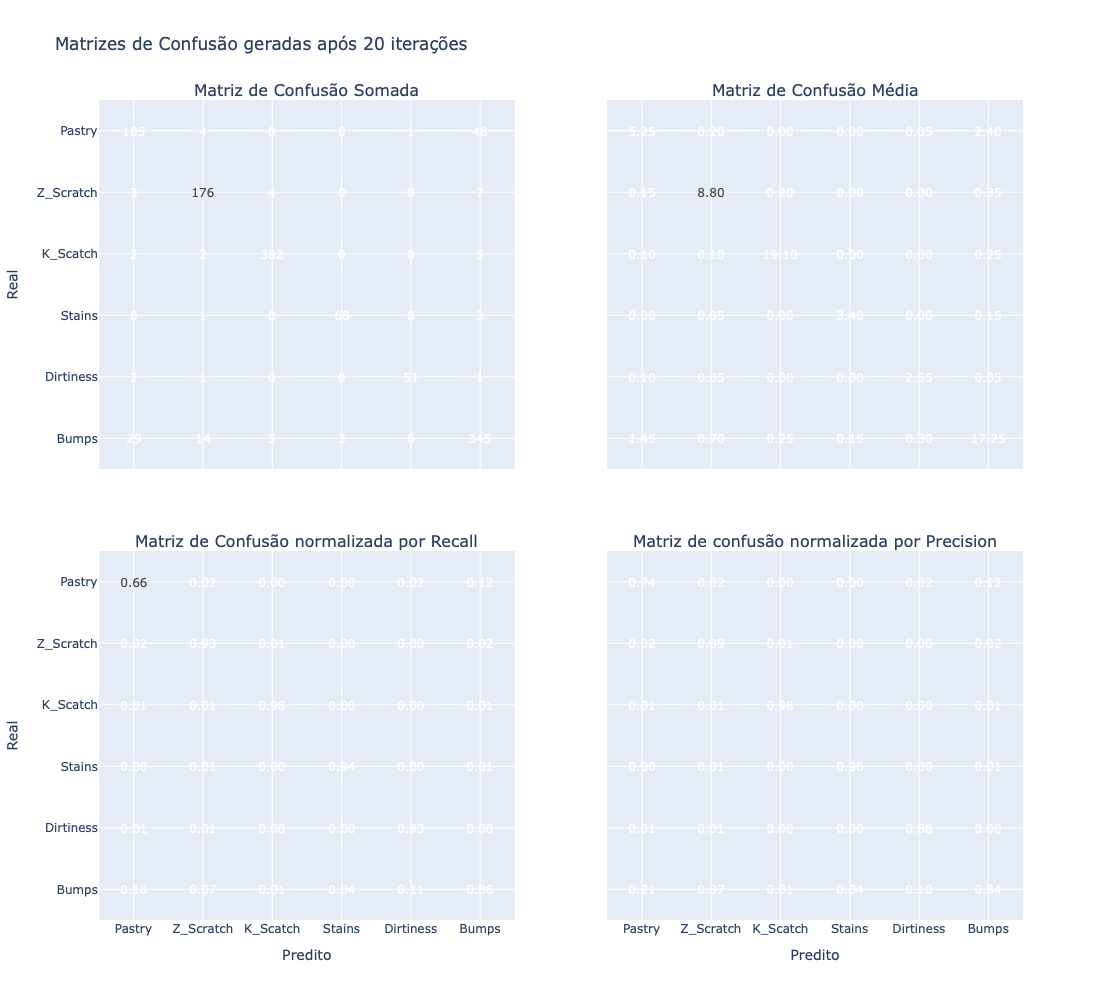

In [69]:
plot_confusion_matrix(knn_res, export=True, filename='knn_cm', path='../figs/metrics')

#### Árvore de Decisão

In [22]:
tree_param_grid = {
    'max_depth': [None, 5, 10, 20, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
}

tree_model = DecisionTreeClassifier()
tree_res = validate_model(tree_model, X, y, tree_param_grid, targets_map=targets_map, n_iter=N_ITER, n_trainval_splits=TRAINVAL_SPLITS)
print_res(tree_res)

  0%|          | 0/20 [00:00<?, ?it/s]

===> ACURÁCIA MÉDIA <===
(86.74 ± 5.35)%

===> MATRIZ DE CONFUSÃO GERAL <===
[[110   4   1   0   3  40]
 [  2 177   1   0   0  10]
 [  2   3 375   3   0   8]
 [  0   1   2  63   0   6]
 [  3   0   0   0  47   5]
 [ 49   6   7   8   4 328]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Target       | Recall       (%) | Precision    (%) | F1-Score     (%)
----------------------------------------------------------------------
Pastry       | 69.64 ± 15.83    | 68.75 ± 18.35    | 67.96 ± 15.7    
Z_Scratch    | 92.89 ± 8.99     | 93.39 ± 7.37     | 92.68 ± 5.44    
K_Scatch     | 95.92 ± 3.9      | 97.31 ± 4.39     | 96.55 ± 3.38    
Stains       | 87.08 ± 20.14    | 88.17 ± 12.71    | 85.44 ± 13.1    
Dirtiness    | 85.0 ± 22.23     | 90.0 ± 16.36     | 84.74 ± 16.23   
Bumps        | 81.57 ± 8.31     | 83.19 ± 8.21     | 82.1 ± 6.89     

===> MÉDIA DO RECALL MÉDIO <===
(85.35 ± 9.30)%

===> MÉDIA DO PRECISION MÉDIO <===
(86.80 ± 10.05)%

===> MÉDIA DO F1-SCORE MÉDIO <===
(84.91 ± 9.91)%


In [49]:
plot_accuracies(tree_res, export=True, filename='tree_acc', path='../figs/metrics')

In [50]:
plot_label_metrics(tree_res, 'f1-scores', export=True, filename='tree_f1', path='../figs/metrics')

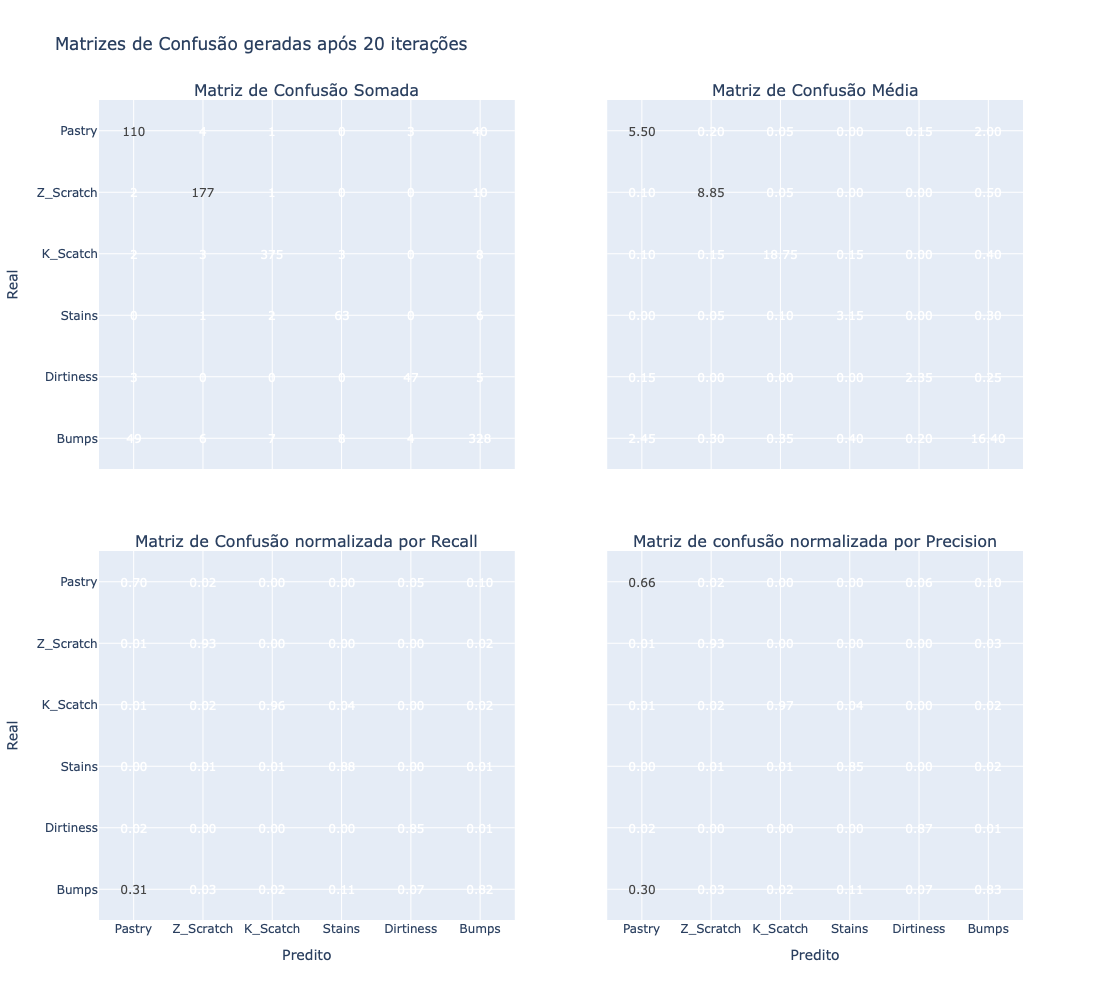

In [70]:
plot_confusion_matrix(tree_res, export=True, filename='tree_cm', path='../figs/metrics')

#### Floresta Aleatória

In [26]:
forest_param_grid = {
    'max_depth': [None, 5, 10, 20, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [100, 50, 200, 500]
}

forest_model = RandomForestClassifier()
forest_res = validate_model(forest_model, X, y, forest_param_grid, targets_map=targets_map, n_iter=N_ITER, 
                            n_trainval_splits=TRAINVAL_SPLITS)
print_res(forest_res)

  0%|          | 0/20 [00:00<?, ?it/s]

===> ACURÁCIA MÉDIA <===
(91.49 ± 3.15)%

===> MATRIZ DE CONFUSÃO GERAL <===
[[123   2   0   0   0  33]
 [  3 171   3   0   0  13]
 [  4   0 381   0   0   6]
 [  0   0   0  67   0   5]
 [  4   0   0   0  47   4]
 [ 23   1   4   2   1 371]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Target       | Recall       (%) | Precision    (%) | F1-Score     (%)
----------------------------------------------------------------------
Pastry       | 77.77 ± 11.03    | 80.53 ± 14.69    | 78.38 ± 10.61   
Z_Scratch    | 90.0 ± 7.27      | 98.39 ± 3.94     | 93.83 ± 4.51    
K_Scatch     | 97.46 ± 3.87     | 98.25 ± 2.45     | 97.8 ± 2.42     
Stains       | 93.33 ± 14.46    | 97.75 ± 6.97     | 94.81 ± 10.07   
Dirtiness    | 85.83 ± 21.13    | 98.33 ± 7.45     | 89.83 ± 14.41   
Bumps        | 92.31 ± 5.54     | 86.46 ± 6.88     | 89.03 ± 4.12    

===> MÉDIA DO RECALL MÉDIO <===
(89.45 ± 6.89)%

===> MÉDIA DO PRECISION MÉDIO <===
(93.28 ± 7.82)%

===> MÉDIA DO F1-SCORE MÉDIO <===
(90.62 ± 6.82)%



In [52]:
plot_accuracies(forest_res, export=True, filename='forest_acc', path='../figs/metrics')

In [53]:
plot_label_metrics(forest_res, 'f1-scores', export=True, filename='forest_f1', path='../figs/metrics')

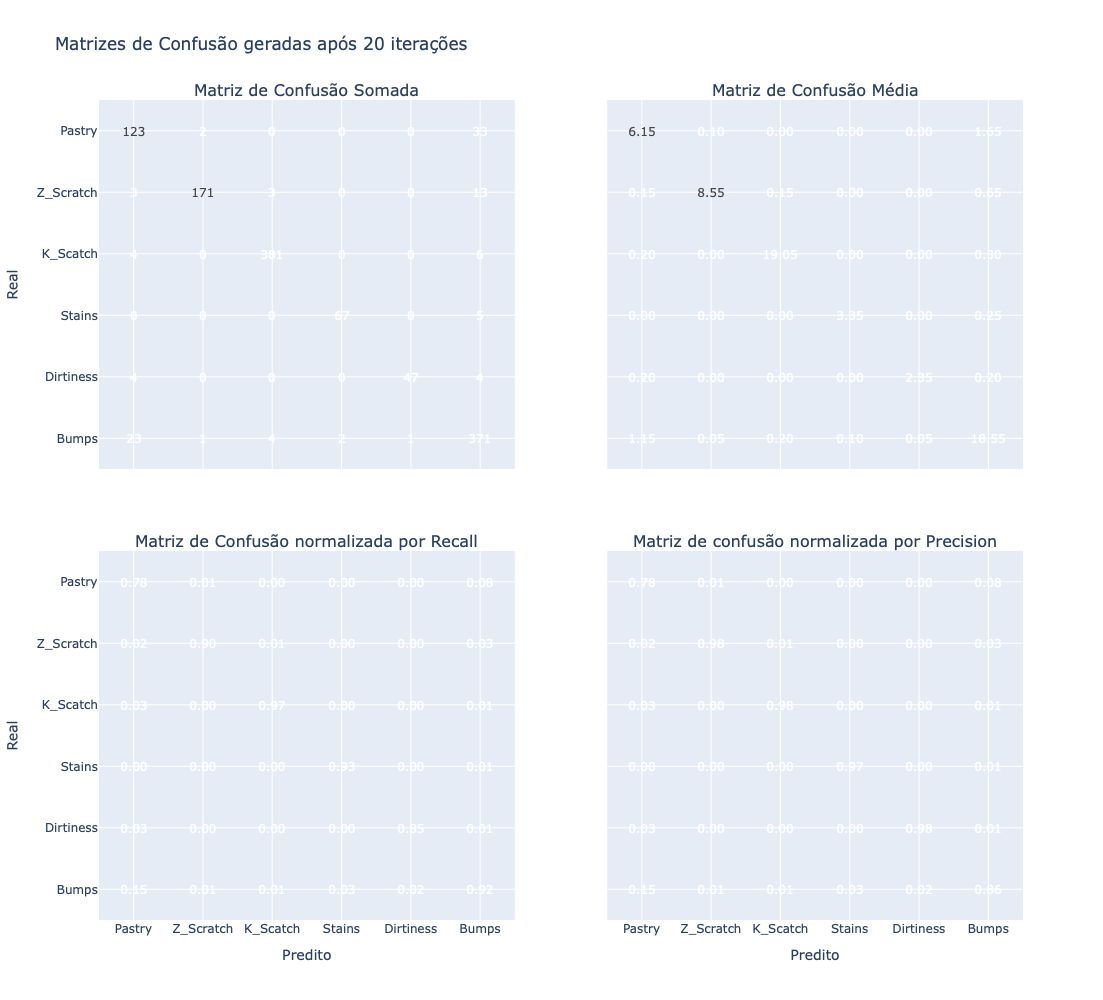

In [71]:
plot_confusion_matrix(forest_res, export=True, filename='forest_cm', path='../figs/metrics')

#### Regressão Logística

Como alguns hiper-parâmetros não funcionam conjuntamente com outros (e.g. `solver=lbfgs` e `penalty=l1`), precisamos nos atentar a estes casos para evitar o treinamento destes modelos e suprimir possíveis erros. Para filtrar combinações inválidas:

In [30]:
lr_param_grid = {
    'model__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],  # lbfgs, newton-cg e sag só funcionam com regularização l2 ou None
    'model__penalty': ['l2', 'l1', 'elasticnet', None],
    'model__l1_ratio': [None, 0.25, 0.5, 0.75],  # Só deve estar presente quando penalty = elasticnet
    'model__C': [1, 0.1, 0.01, 10, 100]  # 0 só para situação em que penalty != None
}

lr_valid_params = []  # Será iterado para trazer todas as combinações de hp válidas
for param in ParameterGrid(param_grid=lr_param_grid):
    if param['model__solver'] in ['lbfgs', 'newton-cg', 'sag'] and param['model__penalty'] in ['l1', 'elasticnet'] or \
       param['model__penalty'] in ['l1', 'l2', None] and param['model__l1_ratio'] is not None or \
       param['model__penalty'] == 'elasticnet' and param['model__l1_ratio'] is None:
        continue  # Em qualquer uma das situações acima, interrompa essa execução do for e vá para a próxima

    if param['model__penalty'] is None:  # Situações específicas que os parâmetros não podem coexistir
        param.pop('model__l1_ratio')
        param.pop('model__C')
        
    
    param = {k: [v] for k, v in param.items()}  # Valor precisa ser uma lista (mesmo que seja um único elemento)
    lr_valid_params.append(param)

lr_valid_params[:5]

[{'model__C': [1],
  'model__l1_ratio': [None],
  'model__penalty': ['l2'],
  'model__solver': ['lbfgs']},
 {'model__C': [1],
  'model__l1_ratio': [None],
  'model__penalty': ['l2'],
  'model__solver': ['newton-cg']},
 {'model__C': [1],
  'model__l1_ratio': [None],
  'model__penalty': ['l2'],
  'model__solver': ['sag']},
 {'model__C': [1],
  'model__l1_ratio': [None],
  'model__penalty': ['l2'],
  'model__solver': ['saga']},
 {'model__C': [1],
  'model__l1_ratio': [None],
  'model__penalty': ['l1'],
  'model__solver': ['saga']}]

In [31]:
lr_model = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=5000))])
lr_res = validate_model(lr_model, X, y, lr_valid_params, targets_map=targets_map, n_iter=N_ITER, n_trainval_splits=TRAINVAL_SPLITS)
print_res(lr_res)

  0%|          | 0/20 [00:00<?, ?it/s]

===> ACURÁCIA MÉDIA <===
(86.98 ± 4.05)%

===> MATRIZ DE CONFUSÃO GERAL <===
[[116   9   1   1   4  27]
 [  2 165   5   0   5  13]
 [  1   3 376   2   1   8]
 [  0   1   0  69   0   2]
 [  6   1   0   0  40   8]
 [ 29  19   8   3   6 337]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Target       | Recall       (%) | Precision    (%) | F1-Score     (%)
----------------------------------------------------------------------
Pastry       | 73.48 ± 11.3     | 77.17 ± 14.18    | 74.54 ± 10.21   
Z_Scratch    | 86.72 ± 9.13     | 83.86 ± 9.09     | 84.95 ± 7.46    
K_Scatch     | 96.17 ± 3.65     | 96.56 ± 3.57     | 96.29 ± 2.4     
Stains       | 95.83 ± 10.3     | 93.5 ± 12.15     | 93.78 ± 8.32    
Dirtiness    | 73.33 ± 29.32    | 71.42 ± 28.34    | 69.48 ± 24.3    
Bumps        | 83.82 ± 6.66     | 85.42 ± 6.65     | 84.54 ± 6.21    

===> MÉDIA DO RECALL MÉDIO <===
(84.89 ± 10.15)%

===> MÉDIA DO PRECISION MÉDIO <===
(84.66 ± 9.51)%

===> MÉDIA DO F1-SCORE MÉDIO <===
(83.93 ± 10.47)%

In [55]:
plot_accuracies(lr_res, export=True, filename='reglog_acc', path='../figs/metrics')

In [56]:
plot_label_metrics(lr_res, 'f1-scores', export=True, filename='reglog_f1', path='../figs/metrics')

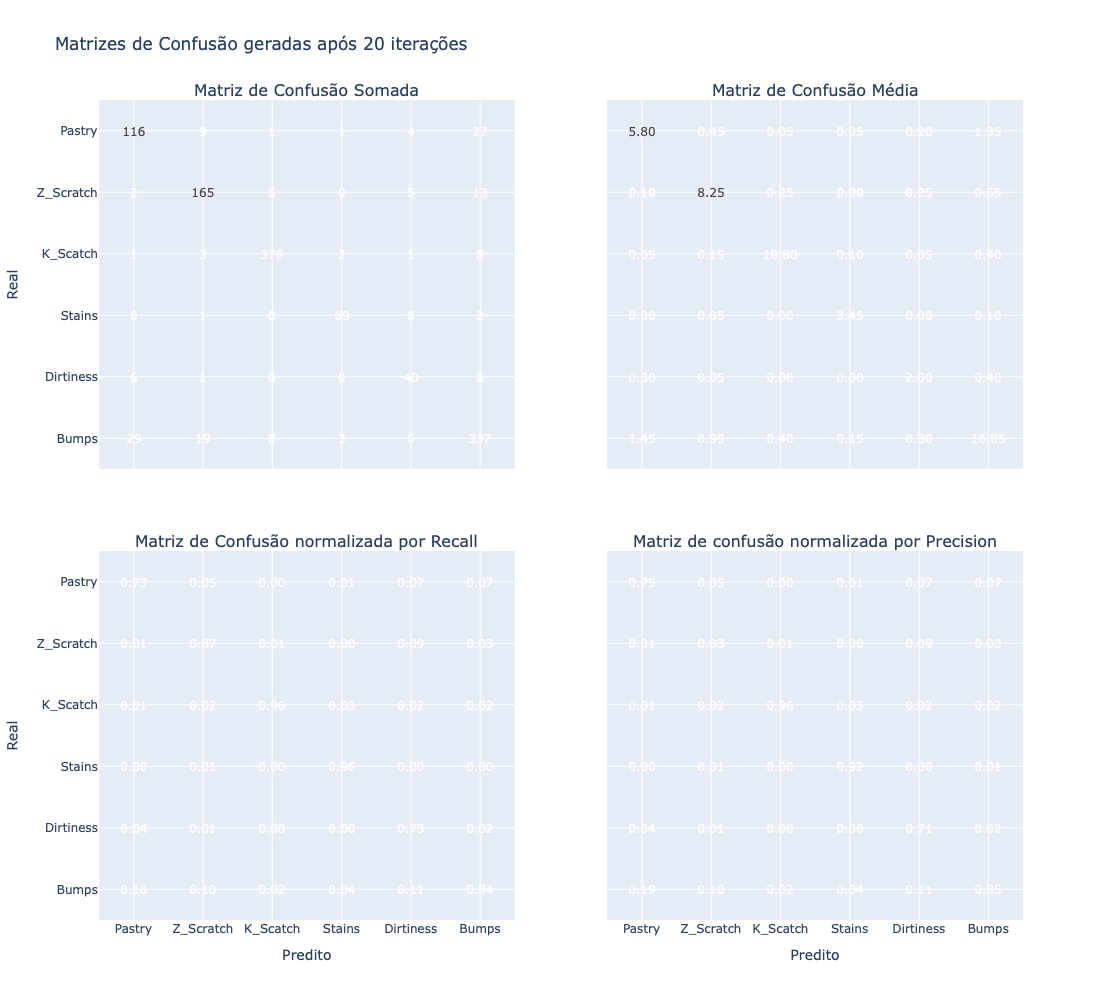

In [72]:
plot_confusion_matrix(lr_res, export=True, filename='reglog_cm', path='../figs/metrics')

#### Naive Bayes

Para a aplicação do Naive Bayes, parte-se do pressuposto de que as variáveis são normais. Dito isto, vamos realizar o teste de normalidade nos nossos dados. Adotaremos $\alpha = 5\%$ para o nosso teste de hipótese:

In [35]:
norm_test = ss.normaltest(X)
p_values = norm_test.pvalue
p_values

array([1.07711748e-063, 2.44425455e-045, 3.24409258e-172, 3.27678541e-172,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       3.06319821e-002, 9.96831475e-104, 6.86068261e-052, 0.00000000e+000,
       0.00000000e+000, 1.49237391e-140, 7.00247671e-042, 2.49006122e-008,
       1.34451955e-233, 2.31342936e-233, 9.84112897e-045, 6.19329869e-174,
       0.00000000e+000, 6.89883286e-051, 1.07076855e-050, 2.65492848e-006,
       1.71768968e-116, 2.05156051e-071, 0.00000000e+000])

In [36]:
p_values >= 0.05

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

Como nenhuma variável é normal, é impossível aplicar o Naive Bayes.

#### Support Vector Machine (SVM)

Assim como feito para a Regressão Logística, iremos filtrar os hiper-parâmetros do SVM que não podem/não fazem sentido ser combinados. Para este caso, apenas o grau quando o kernel é polinomial.

In [37]:
svc_param_grid = {
    'model__C': [1, 0.1, 0.01, 10, 100],
    'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'model__degree': [3, 2, 4, 5],
    'model__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}

svc_valid_params = []  # Será iterado para trazer todas as combinações de hp válidas
for param in ParameterGrid(param_grid=svc_param_grid):
    if param['model__kernel'] != 'poly' and param['model__degree'] != 3:  # Qualquer situação que não seja o default (só utilizado no kernel poly)
        continue
        
    param = {k: [v] for k, v in param.items()}  # Valor precisa ser uma lista (mesmo que seja um único elemento)
    svc_valid_params.append(param)

svc_valid_params[:5]

[{'model__C': [1],
  'model__degree': [3],
  'model__gamma': ['scale'],
  'model__kernel': ['rbf']},
 {'model__C': [1],
  'model__degree': [3],
  'model__gamma': ['scale'],
  'model__kernel': ['linear']},
 {'model__C': [1],
  'model__degree': [3],
  'model__gamma': ['scale'],
  'model__kernel': ['poly']},
 {'model__C': [1],
  'model__degree': [3],
  'model__gamma': ['scale'],
  'model__kernel': ['sigmoid']},
 {'model__C': [1],
  'model__degree': [3],
  'model__gamma': ['auto'],
  'model__kernel': ['rbf']}]

In [38]:
svc_model = Pipeline([('scaler', StandardScaler()), ('model', SVC())])

svc_res = validate_model(svc_model, X, y, svc_valid_params, targets_map=targets_map, n_iter=N_ITER, n_trainval_splits=TRAINVAL_SPLITS)
print_res(svc_res)

  0%|          | 0/20 [00:00<?, ?it/s]

===> ACURÁCIA MÉDIA <===
(90.54 ± 3.14)%

===> MATRIZ DE CONFUSÃO GERAL <===
[[120   2   1   0   3  32]
 [  2 177   5   0   0   6]
 [  2   2 381   0   0   6]
 [  0   1   0  67   0   4]
 [  5   0   0   0  46   4]
 [ 25  10   3   3   4 357]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Target       | Recall       (%) | Precision    (%) | F1-Score     (%)
----------------------------------------------------------------------
Pastry       | 75.98 ± 12.73    | 79.56 ± 11.61    | 76.86 ± 9.04    
Z_Scratch    | 93.0 ± 6.4       | 92.97 ± 8.76     | 92.73 ± 5.87    
K_Scatch     | 97.45 ± 3.08     | 97.79 ± 2.91     | 97.58 ± 2.25    
Stains       | 93.33 ± 14.46    | 96.5 ± 8.6       | 93.92 ± 9.49    
Dirtiness    | 84.17 ± 21.27    | 87.92 ± 18.03    | 84.36 ± 16.25   
Bumps        | 88.81 ± 7.19     | 87.64 ± 6.79     | 88.01 ± 5.57    

===> MÉDIA DO RECALL MÉDIO <===
(88.79 ± 7.73)%

===> MÉDIA DO PRECISION MÉDIO <===
(90.40 ± 6.78)%

===> MÉDIA DO F1-SCORE MÉDIO <===
(88.91 ± 7.50)%



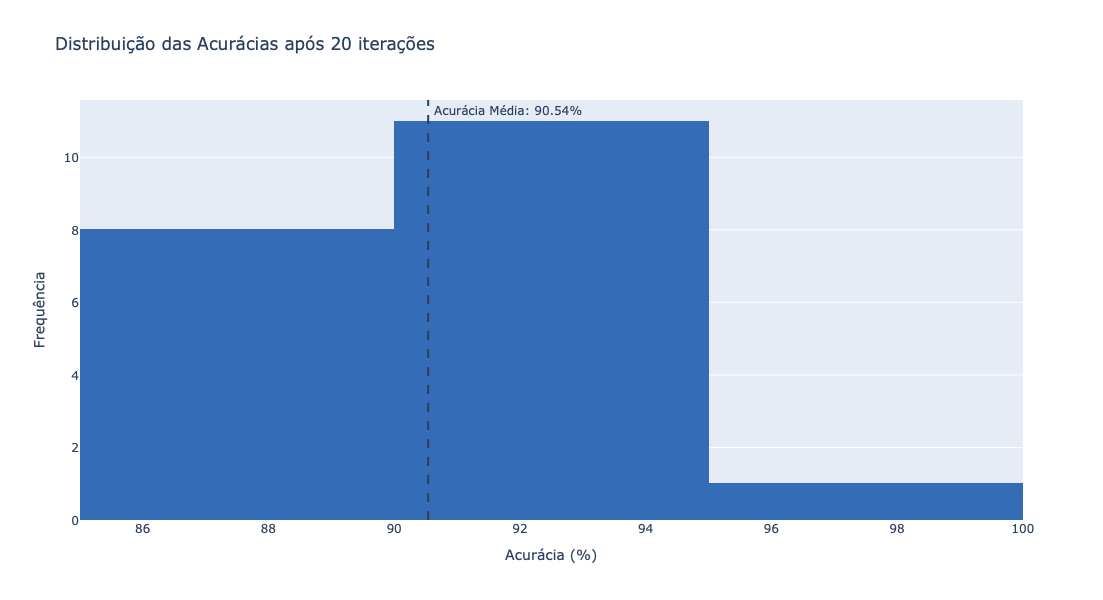

In [58]:
plot_accuracies(svc_res, export=True, filename='svc_acc', path='../figs/metrics')

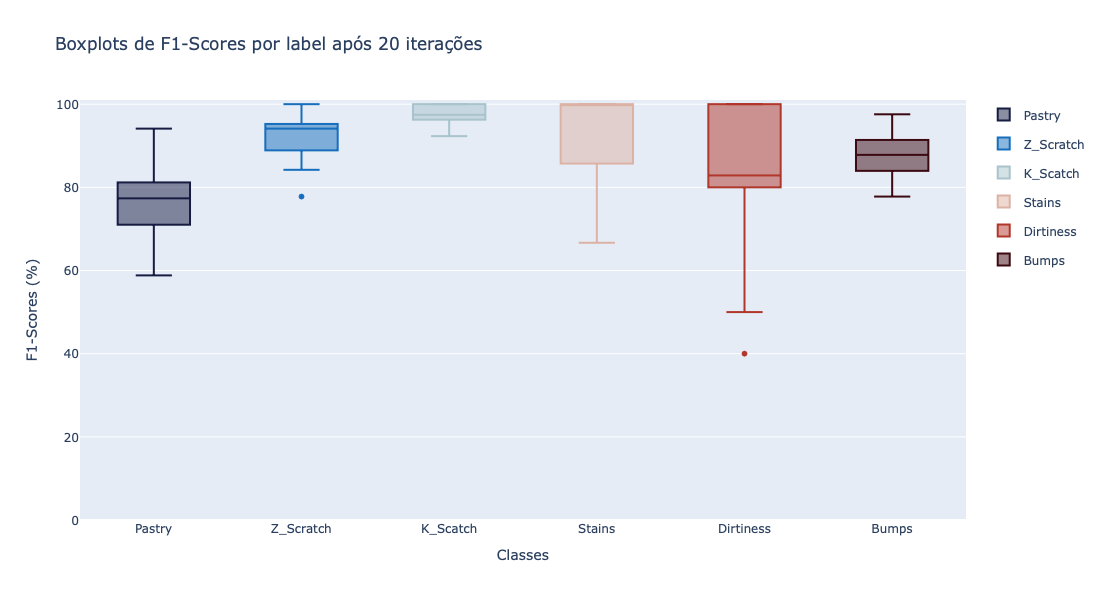

In [59]:
plot_label_metrics(svc_res, 'f1-scores', export=True, filename='svc_f1', path='../figs/metrics')

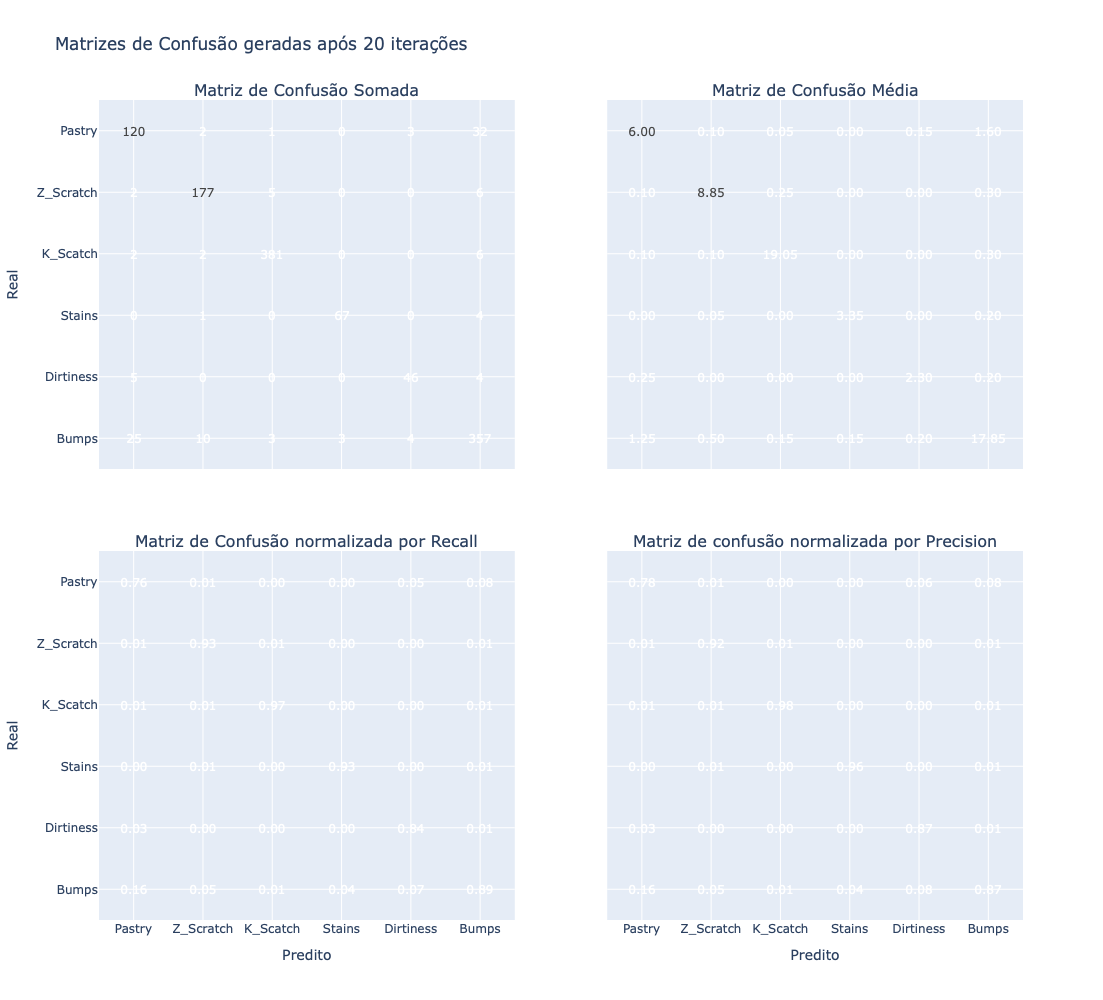

In [73]:
plot_confusion_matrix(svc_res, export=True, filename='svc_cm', path='../figs/metrics')

#### Multi Layer Perceptron (MLP)

In [42]:
mlp_param_grid = {
    'model__hidden_layer_sizes': [(10, ), (50,), (100,), (200,)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam', 'sgd'], # Justificar ausência do lfbgf
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive']
}

mlp_model = Pipeline([('scaler', StandardScaler()), ('model', MLPClassifier(max_iter=100_000, validation_fraction=0.2,
                                                                            n_iter_no_change=200, tol=0.0001, early_stopping=True))])
mlp_res = validate_model(mlp_model, X, y, mlp_param_grid, targets_map=targets_map, n_iter=N_ITER, n_trainval_splits=TRAINVAL_SPLITS)
print_res(mlp_res)

  0%|          | 0/20 [00:00<?, ?it/s]

===> ACURÁCIA MÉDIA <===
(90.06 ± 2.69)%

===> MATRIZ DE CONFUSÃO GERAL <===
[[122   2   1   0   2  31]
 [  1 174   2   0   2  11]
 [  1   2 381   1   0   6]
 [  0   0   0  69   0   3]
 [  6   2   0   0  43   4]
 [ 24  14   6   3   2 353]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Target       | Recall       (%) | Precision    (%) | F1-Score     (%)
----------------------------------------------------------------------
Pastry       | 77.32 ± 13.26    | 80.44 ± 11.96    | 78.08 ± 9.62    
Z_Scratch    | 91.39 ± 8.32     | 90.53 ± 8.71     | 90.51 ± 5.59    
K_Scatch     | 97.43 ± 3.53     | 97.78 ± 2.99     | 97.55 ± 2.3     
Stains       | 95.83 ± 10.3     | 95.25 ± 9.8      | 95.05 ± 8.18    
Dirtiness    | 78.33 ± 24.24    | 88.75 ± 18.39    | 80.62 ± 17.77   
Bumps        | 87.82 ± 8.73     | 86.82 ± 5.43     | 87.03 ± 5.32    

===> MÉDIA DO RECALL MÉDIO <===
(88.02 ± 8.59)%

===> MÉDIA DO PRECISION MÉDIO <===
(89.93 ± 6.19)%

===> MÉDIA DO F1-SCORE MÉDIO <===
(88.14 ± 7.76)%



In [61]:
plot_accuracies(mlp_res, export=True, filename='mlp_acc', path='../figs/metrics')

In [62]:
plot_label_metrics(mlp_res, 'f1-scores', export=True, filename='mlp_f1', path='../figs/metrics')

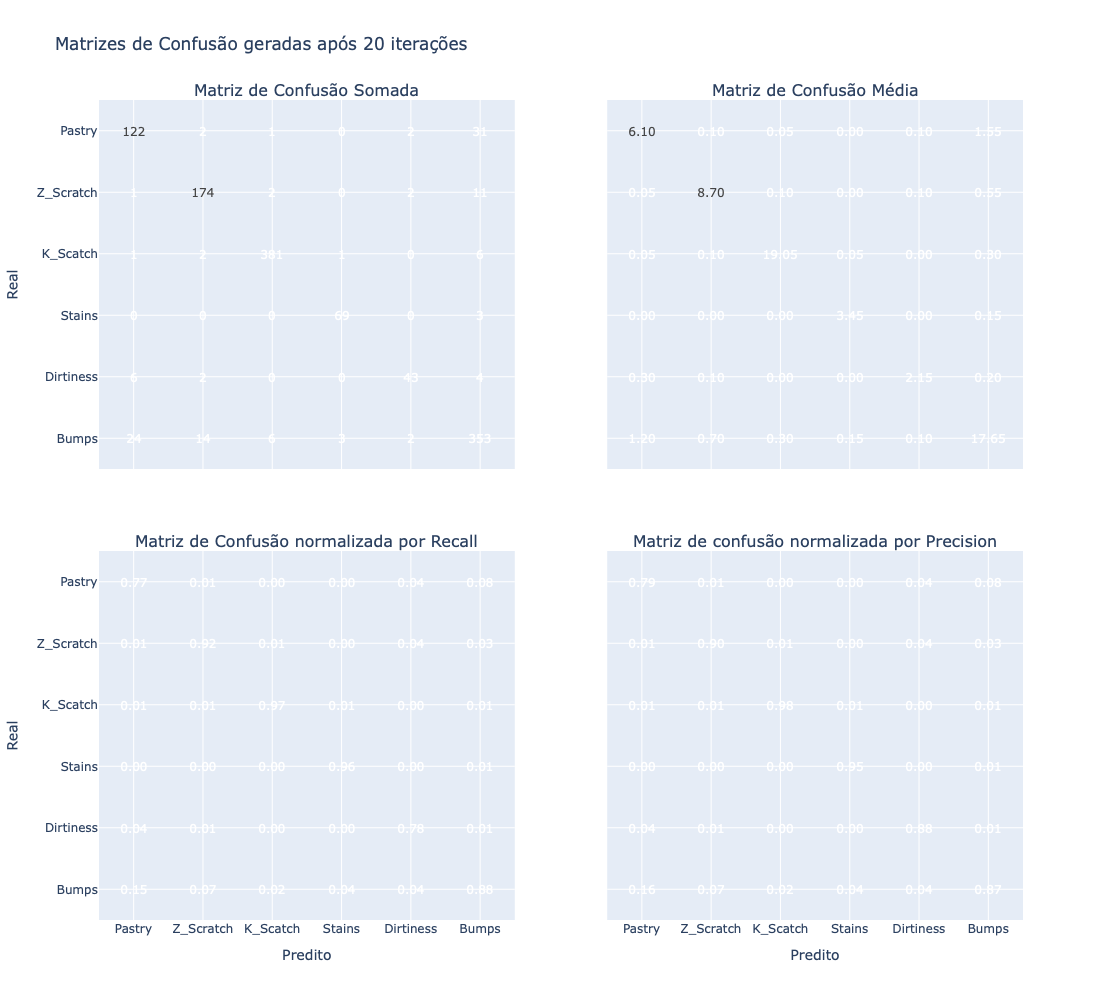

In [74]:
plot_confusion_matrix(mlp_res, export=True, filename='mlp_cm', path='../figs/metrics')